# Merge TrackMate tracks with CellProfile Stardist segmentation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import scipy.spatial.distance
import seaborn as sns

## Define input and output filenames

### Input

In [2]:
tm_data_path = 'TrackMate_merged.csv'
sd_data_path = 'Stardist.csv'

### Output

In [3]:
output_merged_path = 'stardist_trackmate_merged.csv'

## Read input CSV files
We also normalize column names and group each dataframe by Site and Frame for later batched processing.

In [4]:
tm = pd.read_csv(tm_data_path, index_col=0)
tmg = tm.rename(
    columns={
        'FRAME': 'Frame',
        'POSITION_X': 'X',
        'POSITION_Y': 'Y',
    }
).groupby(['Site', 'Frame'])

In [5]:
sd = pd.read_csv(sd_data_path, header=[0, 1])
sdg = sd.set_axis(
    sd.columns.map(lambda x: f'{x[0]}_{x[1]}'),
    axis='columns',
).rename(
    columns={
        'Image_Metadata_T': 'Frame',
        'Image_Metadata_Site': 'Site',
        'Stardist_Location_Center_X': 'X',
        'Stardist_Location_Center_Y': 'Y',
    }
).groupby(['Site', 'Frame'])

Error checking &mdash; Make sure the row (cell) count is aligned for each Site/Frame pair between the two input files.

In [6]:
assert (tmg.size() == sdg.size()).all()

## Plot cell count over time for each site
This serves as a further visual confirmation that the files were properly aligned.

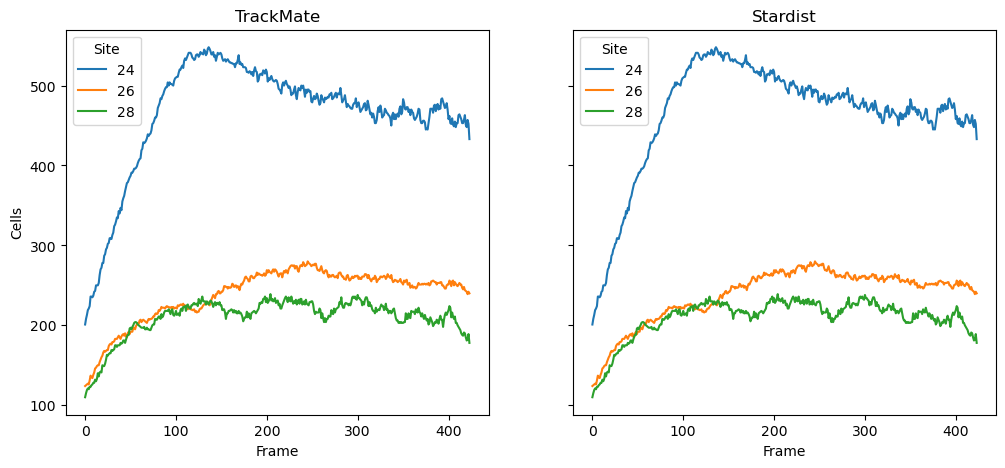

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
ax1.set_ylabel('Cells')
tmg.size().reset_index().pivot(columns='Site', index='Frame').droplevel(0, 'columns').plot(ax=ax1, title='TrackMate')
sdg.size().reset_index().pivot(columns='Site', index='Frame').droplevel(0, 'columns').plot(ax=ax2, title='Stardist');

## Align table rows by closest X,Y distance
Match each row from the Trackmate file with the closest cell from the Stardist file. We verify that every row is matched uniquely. We also compute the distance between the matched X,Y positions for later plotting.

Due to the nature of the distance error between the Trackmate and Stardist positions, it seems that we always get a reliable 1:1 match if we start with the TM points then find the closest SD point for each, rather than the other way around. If we start with the SD points there are sometimes ambiguities and that would require a more complex matching algorithm.

In [8]:
err_all = []
for ((site, frame), tms), (_, sds) in zip(tmg, sdg):
    sds_idx = np.argmin(scipy.spatial.distance.cdist(tms[['X', 'Y']], sds[['X', 'Y']]), axis=1)
    if len(np.unique(sds_idx)) != len(sds_idx):
        raise Exception(f"Detected non-unique row match at site:{site} frame:{frame}")
    sd.loc[sds.index[sds_idx], ('Trackmate', 'Label')] = tms.LABEL.values
    diff = tms[['X', 'Y']].values - sds.iloc[sds_idx][['X', 'Y']].values
    err = np.linalg.norm(diff, axis=1)
    err_all.append(pd.DataFrame({'Site': site, 'Frame': frame, 'Error': err}))
err_all = pd.concat(err_all)

## Plot distance error boxplot for each frame, for each site.
This is to visually confirm that the matched cell positions were all very close. The vast majority of the distances should be much less than 1, with a few outliers per frame going as high as 10.

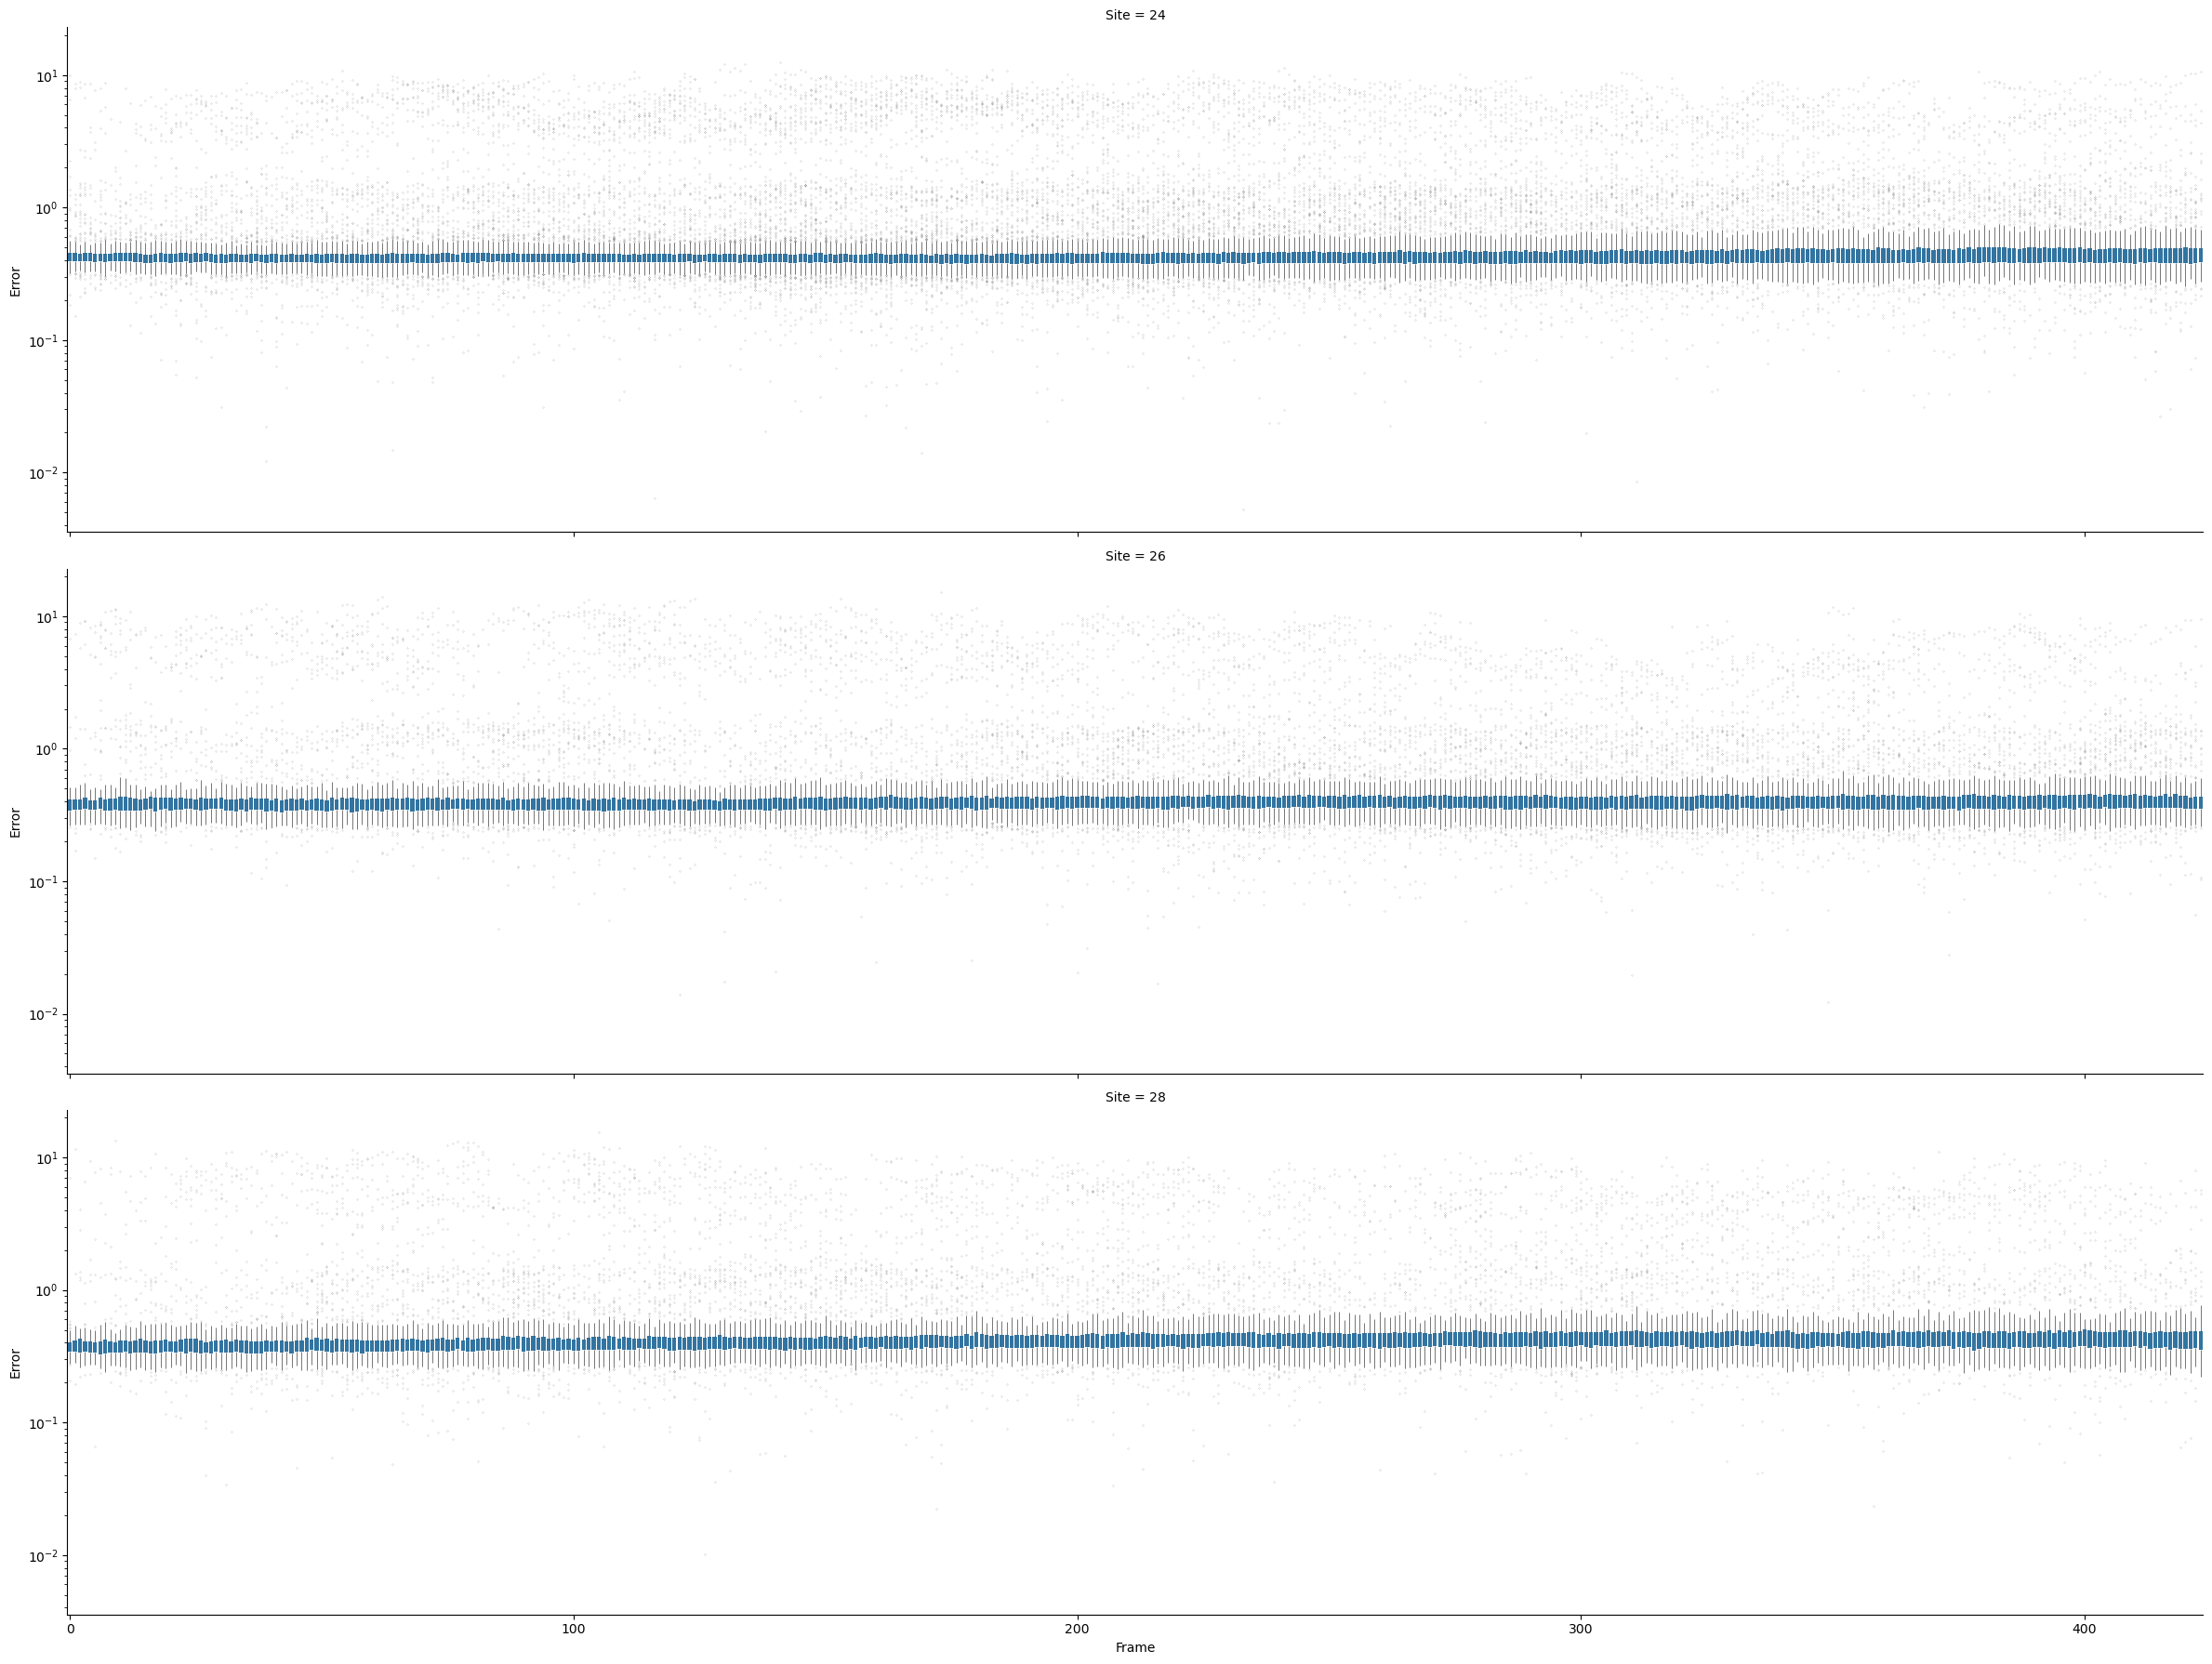

In [9]:
fg = sns.FacetGrid(
    err_all,
    row='Site',
    height=6,
    aspect=4,
)
fg.map_dataframe(
    sns.boxplot,
    x='Frame',
    y='Error',
    capwidths=0,
    fliersize=0.1,
    boxprops={'lw': 0},
    medianprops={'lw': 0},
    whiskerprops={'lw': 0.5},
    log_scale=(False, 10),
)
locator = mticker.MultipleLocator(100)
for ax in fg.axes.flat:
    ax.xaxis.set_major_locator(locator)

Error check &mdash; ensure every row was matched and received a TrackMate label.

In [10]:
assert sd[('Trackmate', 'Label')].notna().all()

## Write results file
The output is the original Stardist/Cellprofiler table plus the new TrackMate label colum,n

In [11]:
sd.to_csv(output_merged_path, index=False)